# Import necessary libraries

In [1]:
#!pip install langchain langchain-community chromadb tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma

from langchain_ollama.llms import OllamaLLM
from langchain.chains import RetrievalQA

import ipywidgets as widgets
from IPython.display import display, clear_output

import os
import time
from typing import List
#from tenacity import retry, wait_exponential, stop_after_attempt

from tqdm.notebook import tqdm

# 1. Data Understanding

## 1.1 Data Verification

In [2]:
%matplotlib inline
sns.set(style="whitegrid")

# Load the dataset
# Update the filename/path as necessary
df = pd.read_csv('Resume.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("Columns available:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())
print("\nDataset info:")
df.info()

# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", num_duplicates)

Dataset shape: (2484, 4)
Columns available: ['ID', 'Resume_str', 'Resume_html', 'Category']

First few rows:


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB

Missing values per column:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

Number of duplicate rows: 0


## 1.2. Exploratory Data Analysis (EDA)


Resume word count statistics:
count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: Resume_word_count, dtype: float64


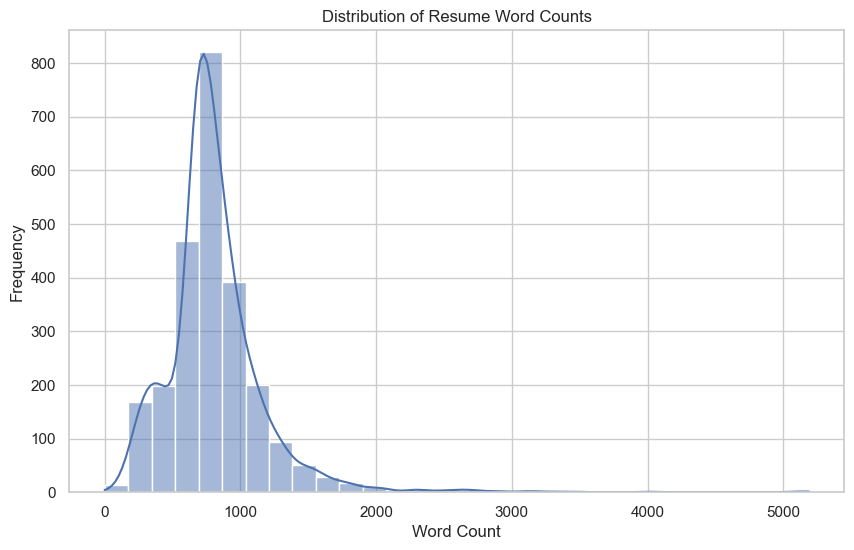

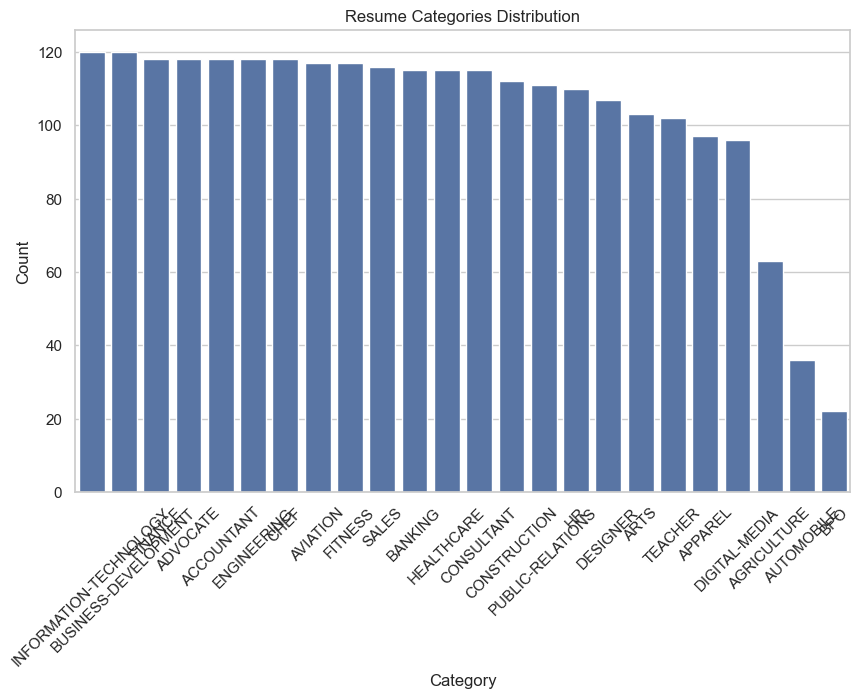

In [3]:
# Analyze the length of resumes (based on the 'resume_str' column)
df['Resume_word_count'] = df['Resume_str'].apply(lambda x: len(str(x).split()))
print("\nResume word count statistics:")
print(df['Resume_word_count'].describe())

# Histogram of resume word counts
plt.figure(figsize=(10, 6))
sns.histplot(df['Resume_word_count'], bins=30, kde=True)
plt.title('Distribution of Resume Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of resume categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title('Resume Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2. Data Preparation

## 2.1 General Data Preparation

In [4]:
# Define a function to clean HTML content using BeautifulSoup
def clean_html(raw_html):
    """
    Remove HTML tags and return plain text.
    """
    # If input is not a string (e.g., NaN), return empty string or original value
    if not isinstance(raw_html, str):
        return raw_html
    return BeautifulSoup(raw_html, "html.parser").get_text()

# Create a new column for cleaned resume text from the HTML version.
# You may prefer resume_str; adjust accordingly if needed.
df['Clean_resume'] = df['Resume_html'].apply(clean_html)

# Further cleaning: remove extra spaces and convert text to lowercase
df['Clean_resume'] = df['Clean_resume'].apply(lambda x: re.sub('\s+', ' ', x).strip() if isinstance(x, str) else x)
df['Clean_resume'] = df['Clean_resume'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# To keep a cleaned version of resume_str as well:
df['Clean_resume_str'] = df['Resume_str'].apply(lambda x: re.sub('\s+', ' ', str(x)).strip().lower())

# Check the result of cleaning
print("\nCleaned resume preview:")
display(df[['ID', 'Clean_resume']].head())


Cleaned resume preview:


,ID,Clean_resume
0,16852973,hr administrator/marketing associate hr admini...
1,22323967,"hr specialist, us hr operations summary versat..."
2,33176873,hr director summary over 20 years experience i...
3,27018550,"hr specialist summary dedicated, driven, and d..."
4,17812897,hr manager skill highlights hr skills hr depar...


## 2.2 Preparation for RAG Pipeline

In [6]:
# Instantiate the embeddings model using all‑MiniLM‑L6‑v2
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Process each resume into a Document object with a progress bar
documents = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparing documents"):
    text = row['Clean_resume']
    metadata = {"id": row['ID'], "category": row['Category']}
    documents.append(Document(page_content=text, metadata=metadata))

# Define a directory to persist the Chroma DB vector store
persist_directory = "./chroma_db_resume"

# Create the vector store from the documents using the HuggingFace embeddings
vectorstore = Chroma.from_documents(documents, embedding_model, persist_directory=persist_directory)
vectorstore.persist()

print("Embeddings generated and stored in Chroma DB using all‑MiniLM‑L6‑v2 HuggingFace Embeddings.")


Preparing documents:   0%|          | 0/2484 [00:00<?, ?it/s]

Embeddings generated and stored in Chroma DB using all‑MiniLM‑L6‑v2 HuggingFace Embeddings.


/var/folders/wp/nyzlhv2n30n3bs8b5qvkgvg00000gn/T/ipykernel_51767/3248061629.py:16: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


# 3. Set Up the RAG Pipeline Using Ollama as the LLM

In [7]:
# Instantiate the Ollama LLM (ensure your local Ollama server is accessible at the provided base_url)
llm = OllamaLLM(model="llama3.2", base_url="http://10.50.10.240:10023/")

# Create a RetrievalQA chain using the vectorstore as the retriever.
# The "stuff" chain type concatenates the retrieved documents into the prompt.
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
)

print("RetrievalQA chain is set up and ready for queries using Ollama LLM.")


RetrievalQA chain is set up and ready for queries using Ollama LLM.


# 4. Build the Chatbot UI Using ipywidgets

In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a text area widget for entering the job description or query
job_input = widgets.Textarea(
    value='',
    placeholder='Enter the job description or query...',
    description='Job Query:',
    layout=widgets.Layout(width='600px', height='300px'),
    disabled=False
)

# Create an output area widget to display the chatbot's answer
output_area = widgets.Output(layout=widgets.Layout(border='1px solid black', width='600px', height='300px'))

# Create a submit button widget
submit_button = widgets.Button(
    description="Submit Query",
    button_style='info',
    layout=widgets.Layout(width='200px', height='50px')
)

# Define the button click callback to process the query and display the result
def on_submit(button):
    with output_area:
        clear_output()  # Clear previous output
        query = job_input.value
        print("Job Query:", query)
        print("\nAnswer:")
        answer = qa_chain.run(query)
        print(answer)

# Bind the button click to the callback function
submit_button.on_click(on_submit)

# Arrange the input and output side-by-side
ui = widgets.HBox([job_input, output_area])
display(ui, submit_button)


Button(button_style='info', description='Submit Query', layout=Layout(height='50px', width='200px'), style=But…